In [1]:
# small NYU dataset
!gdown --id '1HFAsEQCDUx0UC63Yv5uKE2Z5Z9cKDMV0' --output nyu_data.zip

# entire NYU dataset
# !gdown --id '1c9XQ_lJYFPROTJWdWxW5ZWm2zlxNEjFS' --output nyu_data.zip

Downloading...
From: https://drive.google.com/uc?id=1HFAsEQCDUx0UC63Yv5uKE2Z5Z9cKDMV0
To: /content/nyu_data.zip
454MB [00:03, 124MB/s]


data

In [2]:
import numpy as np
import torch
import random

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from io import BytesIO
from zipfile import ZipFile

# the following block, loadZipFile, is from the block named loadZipToMem in data.py
# that can be download from https://github.com/ialhashim/DenseDepth/tree/master/PyTorch.
def loadZipFile(zip_file):
    input_zip = ZipFile('nyu_data.zip')
    # extract a file in memory
    data = {name: input_zip.read(name) for name in input_zip.namelist()}

    # decode the bytes to str while putting one RGB image name and corresponding depth name to one row, and the split them.
    # if you plan to train a model on the entire dataset, please use the following code to read names of training samples:
    # train_names = list(row.split(',') for row in (data['data/nyu2_train.csv']).decode("utf-8").split('\n')if len(row) > 0)

    # if you plan to train a model on a small dataset, please use the following code to read names of training samples:
    train_names = list(row.split(',') for row in (data['data/nyu2_train.csv']).decode("utf-8").split('\r\n')if len(row) > 0)
    test_names = list(row.split(',') for row in (data['data/nyu2_test.csv']).decode("utf-8").split('\n')if len(row) > 0)
    return data, train_names, test_names



class NYU_TrainAugmentDataset(Dataset):
    def __init__(self, data, nyu2, transform=None):
        self.data, self.nyu_dataset = data, nyu2
        # the depth range from 0.1m to 10m.
        self.minDepth = 10
        self.maxDepth = 1000

    def __getitem__(self, idx):
        # sample is a list containing names of a RGB image and corresponding depth image
        sample = self.nyu_dataset[idx]
        # PIL.Image.open() Opens and identifies the given image file.
        image = Image.open( BytesIO(self.data[sample[0]]) )
        depth = Image.open( BytesIO(self.data[sample[1]]) )
        # Augmentation: random horizontal flip
        if random.random() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            depth = depth.transpose(Image.FLIP_LEFT_RIGHT)
        # resize the depth ground truth from (640,480) to (320,240) that is consist with the size of the predicted output.
        depth = depth.resize((320, 240))
        
        # go from Numpy’s arrays to PyTorch’s tensors
        # reshape to (H x W x C)
        # normalize image and depth to [0,1], and then multiply all elements in depth by 1000
        # put all elements in RGB image into the range [0, 1]; put all elements in depth into the range [10, 1000]
        # change the dimensions of the tensor to (C x H x W) that meets the size requirement of input in CNN.
        image = torch.clamp(torch.from_numpy(np.array(image).reshape(480,640,3))/255,0,1).permute(2, 0, 1)
        depth = torch.clamp(torch.from_numpy(np.array(depth).reshape(240,320,1))/255*self.maxDepth, self.minDepth, self.maxDepth).permute(2, 0, 1)
        # depth normalization
        depth = self.maxDepth/depth
        sample = {'image': image, 'depth': depth}
        return sample

    def __len__(self):
        return len(self.nyu_dataset)

class NYU_TestDataset(Dataset):
    def __init__(self, data, nyu2, transform=None):
        self.data, self.nyu_dataset = data, nyu2
        # the depth range from 0.1m to 10m.
        self.minDepth = 10
        self.maxDepth = 1000

    def __getitem__(self, idx):
        # sample is a list containing names of a RGB image and corresponding depth image
        sample = self.nyu_dataset[idx]
        # PIL.Image.open() Opens and identifies the given image file.
        image = Image.open( BytesIO(self.data[sample[0]]) )
        depth = Image.open( BytesIO(self.data[sample[1]]) )
        # resize the depth ground truth from (640,480) to (320,240)
        depth = depth.resize((320, 240))
    
        # go from Numpy’s arrays to PyTorch’s tensors
        # reshape to (W x H x W)
        # normalize image and depth to [0,1], and then divide all elements in depth by 10
        # put all elements in RGB image into the range [0, 1]; put all elements in depth into the range [10, 1000]
        # change the dimensions of the tensor to (C x H x W) that meets the size requirement of input in CNN.
        image = torch.clamp(torch.from_numpy(np.asarray(image).reshape(480,640,3))/255,0,1).permute(2, 0, 1)
        depth = torch.clamp(torch.from_numpy(np.asarray(depth).reshape(240,320,1))/10, self.minDepth, self.maxDepth).permute(2, 0, 1)
        # depth normalization
        depth = self.maxDepth/depth
        sample = {'image': image, 'depth': depth}
        return sample

    def __len__(self):
        return len(self.nyu_dataset)

loss

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import exp

def L1loss(y_pred, y_true):
    l1_criterion = nn.L1Loss()
    l_depth = l1_criterion(y_pred, y_true)
    return l_depth

def lossgradient(y_pred, y_true):
    # y_true gradient step=1
    y_pred_left = y_pred
    y_pred_right = F.pad(y_pred, [0, 1, 0, 0])[:, :, :, 1:]
    y_pred_top = y_pred
    y_pred_bottom = F.pad(y_pred, [0, 0, 0, 1])[:, :, 1:, :]
    # dx, dy = torch.abs(right - left), torch.abs(bottom - top)
    dx_pred, dy_pred = y_pred_right - y_pred_left, y_pred_bottom - y_pred_top 
    dx_pred[:, :, :, -1] = 0
    dy_pred[:, :, -1, :] = 0

    # y_true gradient step=1
    y_true_left = y_true
    y_true_right = F.pad(y_true, [0, 1, 0, 0])[:, :, :, 1:]
    y_true_top = y_true
    y_true_bottom = F.pad(y_true, [0, 0, 0, 1])[:, :, 1:, :]
    # dx, dy = torch.abs(right - left), torch.abs(bottom - top)
    dx_true, dy_true = y_true_right - y_true_left, y_true_bottom - y_true_top 
    # dx will always have zeros in the last column, right-left
    # dy will always have zeros in the last row,    bottom-top
    dx_true[:, :, :, -1] = 0
    dy_true[:, :, -1, :] = 0
    
    l_edges = torch.mean(torch.abs(dy_pred - dy_true) + torch.abs(dx_pred - dx_true))
    return l_edges

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, maxDepthVal, window_size=11, window=None, size_average=True, full=False):
    L = maxDepthVal

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs

    return ret

def depth_loss(y_pred, y_true):
    l_depth = L1loss(y_pred, y_true)
    l_edges = lossgradient(y_pred, y_true)
    l_ssim = torch.clamp((1 - ssim(y_pred, y_true, maxDepthVal=1000.0/10.0)) * 0.5, 0, 1)
    
    w1 = 0.1
    w2 = 1.0
    w3 = 1.0
    loss = ((w1 * l_depth) + (w2 * l_edges) + (w3 * l_ssim))
    return loss

model

In [4]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.leakyreluA(self.convA( torch.cat([up_x, concat_with], dim=1)  ) )))
        # return self.leakyreluB( self.convB( self.convA( torch.cat([up_x, concat_with], dim=1)  ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=1664, decoder_width = 1.0):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=0)

        self.up1 = UpSample(skip_input=features//1 + 256, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 128,  output_features=features//4)
        self.up3 = UpSample(skip_input=features//4 + 64,  output_features=features//8)
        self.up4 = UpSample(skip_input=features//8 + 64,  output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[12]
        x_d0 = self.conv2(F.relu(x_block4))

        x_d1 = self.up1(x_d0, x_block3)
        x_d2 = self.up2(x_d1, x_block2)
        x_d3 = self.up3(x_d2, x_block1)
        x_d4 = self.up4(x_d3, x_block0)
        return self.conv3(x_d4)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # pretrained (bool): If True, returns a model pre-trained on ImageNet
        self.original_model = models.densenet169( pretrained=True )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

class DepthModel(nn.Module):
    def __init__(self):
        super(DepthModel, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )

train

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/3][1/43], 7.94 sec(s), Batch loss:0.91702 (Avg:0.91702)
Epoch [1/3][11/43], 5.64 sec(s), Batch loss:0.39099 (Avg:0.58852)
Epoch [1/3][21/43], 5.51 sec(s), Batch loss:0.33690 (Avg:0.45433)
Epoch [1/3][31/43], 5.47 sec(s), Batch loss:0.20610 (Avg:0.38322)
Epoch [1/3][41/43], 5.45 sec(s), Batch loss:0.18816 (Avg:0.33951)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)


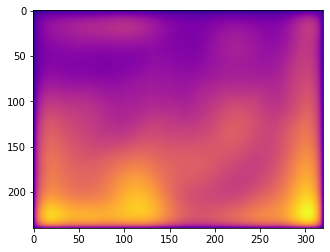

Epoch [1/3], 66.77 sec(s), Avg Train loss:0.08362, Avg Test loss:0.07903
Epoch [2/3][1/43], 5.64 sec(s), Batch loss:0.16973 (Avg:0.16973)
Epoch [2/3][11/43], 5.82 sec(s), Batch loss:0.17133 (Avg:0.19231)
Epoch [2/3][21/43], 6.64 sec(s), Batch loss:0.19235 (Avg:0.18938)
Epoch [2/3][31/43], 6.53 sec(s), Batch loss:0.19182 (Avg:0.18650)
Epoch [2/3][41/43], 6.44 sec(s), Batch loss:0.15915 (Avg:0.18277)


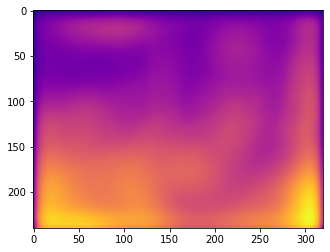

Epoch [2/3], 72.76 sec(s), Avg Train loss:0.04594, Avg Test loss:0.06951
Epoch [3/3][1/43], 5.53 sec(s), Batch loss:0.16331 (Avg:0.16331)
Epoch [3/3][11/43], 5.89 sec(s), Batch loss:0.18198 (Avg:0.17126)
Epoch [3/3][21/43], 5.81 sec(s), Batch loss:0.14249 (Avg:0.16221)
Epoch [3/3][31/43], 5.88 sec(s), Batch loss:0.16672 (Avg:0.16312)
Epoch [3/3][41/43], 5.90 sec(s), Batch loss:0.16754 (Avg:0.16597)


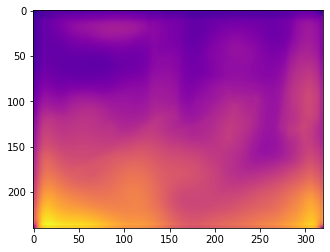

Epoch [3/3], 73.17 sec(s), Avg Train loss:0.04181, Avg Test loss:0.06972


In [5]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def main():
    # send the tensor to GPU if you have a GPU; otherwise, send the tensor to CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Create model
    model = DepthModel().to(device)
    
    # set batch size and the numer of epoches
    batch_size = 4
    num_epoch = 3
    
    # Adam optimizer with learning rate of 0.0001
    optimizer = torch.optim.Adam( model.parameters(), lr=0.0001 )

    # load train and test datasets
    data, train_names, test_names = loadZipFile('nyu_data.zip')
    # a list of tuples, each tuple corrresponding to one RGB tensor and depth ground truth tensor.
    train_set = NYU_TrainAugmentDataset(data, train_names)
    test_set = NYU_TestDataset(data, test_names)
    # slice the dataset to mini-batches, each one mini-batch can be sent to a loop.
    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size, shuffle=False)

    # Start training...
    for epoch in range(num_epoch):
        epoch_start_time = time.time()
        train_loss = 0.0
        test_loss = 0.0
        
        # Switch to train mode
        model.train()
        for i, sample_batched in enumerate(train_loader):
            # zero the gradients
            optimizer.zero_grad()
            # Prepare RGB sample and corresponding depth ground truth, and send only one batch to the device.
            train_image = torch.autograd.Variable(sample_batched['image'].to(device))
            train_depth = torch.autograd.Variable(sample_batched['depth'].to(device))
            # Predict depth
            train_output = model(train_image)
            # Compute the loss between the prediction and the ground truth
            batch_loss = depth_loss(train_output, train_depth)
            # auto-compute all gradients 
            batch_loss.backward()
            # update the parameters of the model using the computed gradients
            optimizer.step()
            
            # accumulate loss
            train_loss += batch_loss.item()
            
            # display information about running speed and batch loss
            if i % 10 == 0:
                print('Epoch [{}/{}][{}/{}], {:.2f} sec(s), Batch loss:{:.5f} (Avg:{:.5f})'
                  .format(epoch+1, num_epoch, i+1, train_loader.__len__(), (time.time()-epoch_start_time)*10/(i+1), batch_loss, train_loss/(i+1)))
        
        
        # switch to test mode 
        model.eval()
        # disable any gradient calculation
        with torch.no_grad():
            for i, sample_batched in enumerate(test_loader):
                # prepare test dataset
                test_image = torch.autograd.Variable(sample_batched['image'].to(device))
                test_depth = torch.autograd.Variable(sample_batched['depth'].to(device))
                # predict
                test_output = model(test_image)
                # loss
                batch_loss = depth_loss(test_output, test_depth)
                
                # accumulate loss
                test_loss += batch_loss.item()
                
                
                # display the depth prediction of last RGB image in test dataset
                if i == len(test_loader)-1:
                    # change the dimensions of the output tensor from (N x C x H x W) to (N x H x W x C)
                    output_depth = test_output.permute(0, 2, 3, 1)
                    # removes all dimensions with a length of one from tensor, it will return a tensor with the size of (H x W)
                    # transfer from tensor to numpy after removing gradients using torch.detach()
                    # output_depth = torch.squeeze(output_depth[-1]).detach().numpy()
                    output_depth = torch.squeeze(output_depth[-1]).cpu().numpy()
                    plt.imshow( output_depth, cmap='plasma' )
                    plt.show()
            
            # display information about running speed of one epoch and batch loss
            print('Epoch [{}/{}], {:.2f} sec(s), Avg Train loss:{:.5f}, Avg Test loss:{:.5f}'
                  .format(epoch+1, num_epoch, time.time()-epoch_start_time, train_loss/train_set.__len__(), test_loss/test_set.__len__()))
            
        
    # save model's parameters
    path = 'nyusmall_para.pt'
    torch.save(model.state_dict(), path)

if __name__ == '__main__':
    main()